In [1]:

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
import functools
from functools import partial
from scipy.stats import norm
from parse_uitf_bond import *
#### deep learning ####
import tensorflow as tf
from seaborn import heatmap
import numpy as np
import os
import time
from matplotlib import pyplot as plt
# hyper-param optimization
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from joblib import dump, load


F:\Users\ARJEPAK\Anaconda3\envs\tensorflow_beta1\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:

# page = requests.get('http://www.uitf.com.ph/daily_navpu_details.php?bank_id=3&fund_id=49&fmonth=06&fday=15&fyear=2018&tmonth=09&tday=13&tyear=2018&captcha_uitf=hydropic&btn=Filter#gsc.tab=0')
# soup = BeautifulSoup(page.content, 'html.parser')
# list(soup.children)
# soup.find_all('table')[0].get_text()

def fill_data(dframe):
    dframe.interpolate(method='linear', inplace=True)
    dframe.fillna(method='bfill', inplace=True)
    dframe.fillna(method='ffill', inplace=True)
    dframe.fillna(value=0, inplace=True)

    return

def linkopt(namelist,optvalues):
    """
    wrapper to link names and values
    """
    xdict={}
    for x,y in zip(namelist,optvalues):
        xdict[x]=y
    
    return xdict

def validation(model, train_data, test_data, loss_array, boolmask, **kwargs):
    """
    -->validation test for autoregressive data of single variable, which is premium bond fund
    -->It will test the stateful RNNs capacity for autoregression.
    model--> trained model
    :param: train_data--> train dataset, TimeSequence object
    :param: test_data--> test dataset, TimeSequence object
    :param: loss_array--> a replicated array based on the future compounded loss
    :param: boolmask--> list or array of indices to be masked
    :param: return--> the absolute mean of the test_data errors, and a printed value
    """

    model.reset_states()
    reshape_sample=tf.reshape(train_data[0][0][-1], (1, train_data[0][0].shape[1], 3))
    predictions = model.predict(tf.boolean_mask(
        reshape_sample, boolmask, axis=1))

    ###start of batch size adjustment###
    # get the last index for singular batch for tests.

    # create container for the model's test output.
    y_pred = []
    y_true = []
    # shift data and replace
    reshape_sample = tf.roll(reshape_sample, -1, axis=1)
    reshape_sample=reshape_sample.numpy()
    reshape_sample[0][-1] = predictions[0]

    for _, test in test_data:
        predictions = model.predict(tf.boolean_mask(
            reshape_sample, boolmask, axis=1))
        y_pred.append(predictions[0][0])
        y_true.append(test[0][0])
        reshape_sample = np.roll(reshape_sample, -1, axis=1)
        reshape_sample[0][-1] = predictions

    y_pred = np.array(y_pred)
    y_pred = np.multiply(y_pred, loss_array)
    y_true = np.array(y_true)
    y_true = np.multiply(y_true, loss_array)

    return mean_absolute_error(y_true, y_pred)


class CustomEarlyStopper:
    def __init__(self, patience=3, delta=1e-4):
        self.prev_loss = 1e6  # high value heuristic
        self.patience = patience
        self.delta = delta

        # changing values:
        self.ctpatience = patience
        self.save = 0

    def main_decider(self, loss):
        """
        :param: loss
        """
        if (loss > self.prev_loss):
            if (loss - self.prev_loss > self.delta):
                return 1
            else:
                if (self.ctpatience > 0):
                    self.ctpatience += -1
                    return 0
                else:
                    return 1
        else:
            self.prev_loss = loss
            self.save = 1
            return 0

def modelfixweight(model, train_data , target_data, class_weight, epoch_internal, **kwargs):
    """
    functional wrapper for model.fit() to fix the class_weight prior to partial transformation
    :return: history object
    """
    return model.fit(train_data,
                    target_data,
                    epochs=epoch_internal,
                    class_weight=class_weight)

def form_dataset(normalized_data, est_period, **kwargs):

    percent_validation = kwargs.pop('percent_validation', 0.8)

    rel_norm=normalized_data

    # end_index=(int(((rel_norm.shape[0]-est_period)*0.9)//batch_size))*batch_size-2

    # batch size to be changed to 1
    # end_index_test=(
    #     (rel_norm.shape[0] - 1 - end_index) // batch_size) * batch_size + end_index -1

    end_index = int((rel_norm.shape[0]-est_period-1)*percent_validation)+est_period-1

    tser_rel_train = tf.keras.preprocessing.sequence.TimeseriesGenerator(rel_norm, rel_norm,
                                                                        length=est_period,
                                                                        sampling_rate=1,
                                                                        end_index=end_index)

    tser_rel_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(rel_norm, rel_norm,
                                                                        length=est_period,
                                                                        sampling_rate=1,
                                                                        batch_size=1,
                                                                        start_index=end_index-19)

    return tser_rel_train, tser_rel_test   

def train_evaluate(normalized_data, est_period,loss_func,param_record, **kwargs):
    """
    :param: train_data---> train dataset, TimeSequence object
    :param: test_data---> test dataset, TimeSequence object
    :param: loss_func---> loss function, function
    """
    global global_training_loss
    masked_indices=kwargs.pop('masked_indices',[4,6,7,9,10,11,12,14,15])
    
    train_data, test_data= form_dataset(normalized_data, est_period)
    boolmask=np.full(est_period,True)
    boolmask[masked_indices]=False

    model_dir = "./training_0"
    # Name of the checkpoint files
    model_prefix = os.path.join(model_dir, "best.model")

    load_model=kwargs.pop('load_model', False)

    future_loss = kwargs.pop('future_loss', 0.9)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(kwargs.pop('input_layer',7),  
        input_shape=(tf.boolean_mask(train_data[0][0],boolmask,axis=1).shape[1], 
            train_data[0][0].shape[2]),  
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l1(
        l=kwargs.pop('uni_reg', 0)),
        use_bias=True))
    model.add(tf.keras.layers.Dense(kwargs.pop('hidden_1',1),    
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l1(
            l=kwargs.pop('hidden_reg', 0)),
        use_bias=True))
    model.add(tf.keras.layers.Dropout(rate = kwargs.pop('dropout_rate',0)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(3,    
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l1(
            l=kwargs.pop('hidden_reg', 0)),
        use_bias=True))   

    xadam=tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=xadam,
        loss=loss)

    dump(param_record, 'hyper_param.joblib') 
    if (load_model==True): #feature is not developed yet.
        model.load_weights(model_prefix)
    # will create improvised early stopper
    # lowest_loss = 1e6  # high value heuristic
    # patience = 8


    ct = 0

    for _ in test_data:
        ct += 1

    powcoeffs = np.arange(ct)
    loss_base = np.full(ct,future_loss)
    loss_array = np.power(loss_base, powcoeffs)
    #loss_array=loss_array.reshape(loss_array.shape[0],1)
    #static_values and hyperparameters
    # initalize early stopping object
    sigma = kwargs.pop('sigma', 1.55)
    earlystopper0 = CustomEarlyStopper(
        delta=1-norm.cdf(sigma, loc=0, scale=1) + norm.cdf(-sigma, loc=0, scale=1), patience=8)
    class_weight = kwargs.pop('class_weight', {0: 0.6, 1: 0.1, 2: 0.3})
    epochs = kwargs.pop('epochs', 34)

    ctepochs = 0

    # initialize the mean_loss
    epoch_internal = kwargs.pop('epoch_internal', 1)
    efftrainblock = partial(
        modelfixweight, class_weight=class_weight, model=model, epoch_internal = epoch_internal)

    history = efftrainblock(train_data=tf.boolean_mask(train_data[0][0],boolmask,axis=1), target_data=train_data[0][1])
    mean_loss = validation(model, train_data, test_data, loss_array, boolmask)

    while(earlystopper0.main_decider(mean_loss) == 0 and ctepochs < epochs):
        if (earlystopper0.save == 1):
            model.save_weights(model_prefix)
            global_training_loss=history.history['loss'][0]
            earlystopper0.save = 0
        history = efftrainblock(train_data=tf.boolean_mask(train_data[0][0],boolmask,axis=1), target_data=train_data[0][1])
#         history=model.fit(train_data,
#             epochs=1,
#             class_weight=class_weight)

        # check if history has the current output
        mean_loss = validation(model, train_data, test_data, loss_array, boolmask)        
        print('epoch {} mean_loss = {}'.format(ctepochs, mean_loss))

        ctepochs += epoch_internal

    # return loss of best model    
    model.load_weights(model_prefix)
    mean_loss = validation(model, train_data, test_data, loss_array, boolmask)

    return mean_loss



In [3]:
dfrel=pd.read_csv('fin_normdataset.csv',parse_dates=True,index_col=0)

In [5]:
dfrel.loc[:, 'inflation'].interpolate(
    method='linear', limit_area='inside').dropna().to_csv('inflation_actual_f.csv', header=True)

In [6]:
def get_outernan(column):
    """
    returns a tuple with no. of timesteps to forecast forward and backward
    """
    zerolist=np.nonzero(column.notnull().values)
    return (zerolist[0][0],column.shape[0]-zerolist[0][-1]-1)

In [7]:
dftemp = pd.read_csv('pb_forecast_f.csv', index_col=None)
get_outernan(dfrel.loc[:, 'inflation']) #gets the x and y values

dfrel.iloc[-15:, 2] = dftemp.loc[:, 'Point Forecast'].values

dftemp = pd.read_csv('pb_forecast_b.csv', index_col=None)
dfrel.iloc[:6, 2][::-1] = dftemp.loc[:, 'Point Forecast'].values 

fill_data(dfrel) #fills the missing data through forward, backwards fill, and linear interpolation

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000205DA428E10>,
      dtype=object)

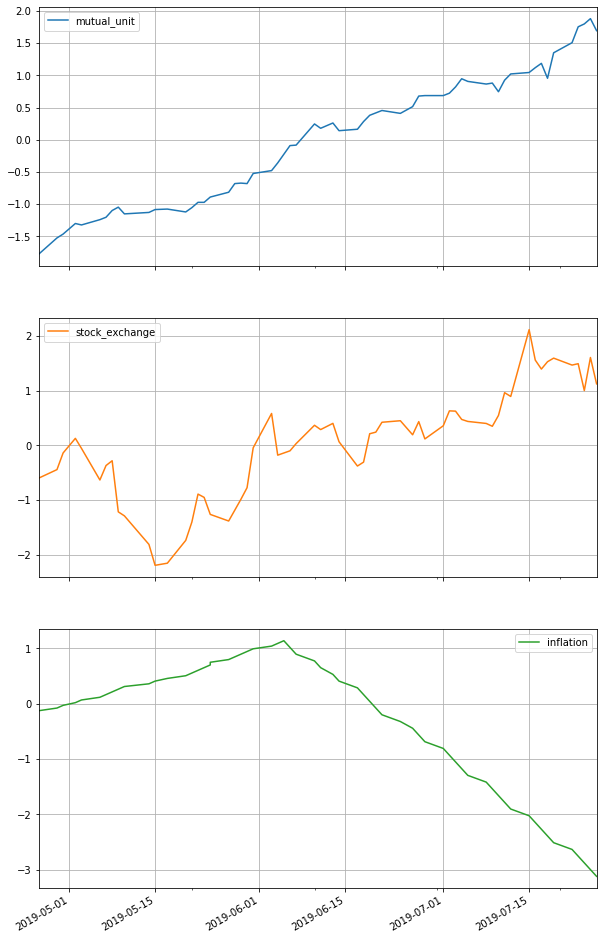

In [8]:

dfrel.plot(subplots=True, figsize=(10, 6*3), grid=True)


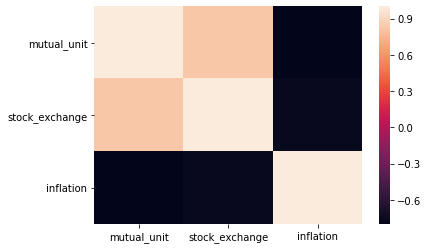

In [9]:
dfcorr = dfrel.corr()
heatmap(dfrel.corr())

In [10]:
dftemp00 = dfcorr.loc[:'mutual_unit'].abs()
sumvars = dftemp00.apply(sum, axis=1)
dftemp00/sumvars.values[0]

,mutual_unit,stock_exchange,inflation
mutual_unit,0.380704,0.315471,0.303826


In [11]:

#scaler_obj = preprocessing.StandardScaler().fit(dfrel.values)


In [12]:


#rel_norm = scaler_obj.transform(dfrel.values)



In [13]:

rel_norm = dfrel.values.astype('float32')  # expected tensor data type



In [14]:

def loss(explanvar, targetvar):
    return tf.keras.metrics.mean_absolute_error(
        explanvar,
        targetvar)



In [15]:


# define patch global variable for loss value with best mean_loss
global_training_loss=1e6



In [16]:
space = [Integer(2, 21, name='input_layer'), #number of neurons in input layer
        Integer(1,3, name='hidden_1'),       #number of neurons in the 1st hidden layer
        Real(0.0, 0.3, name='navpu_infl'),   #adjustment of class weighting in the mutual_unit(navpu) and the inflation. 
        Real(0.0, 0.8, name='uni_reg'),      # regularization factor in the 1st hidden layer 
        Real(0.0, 0.5, name='dropout_rate'), #dropout fraction on the weights outside the 1st hidden layer
        Real(0.0, 0.8, name='hidden_reg'),   #regularization at the final layer
        ]


In [17]:
# create partial function for train_evaluate for efficiency in calls
hyp_train_eval = partial(train_evaluate, rel_norm, loss_func=loss, percent_validation=0.8,
                         epochs=750, est_period= 20, sigma=1.3, load_model=False, epoch_internal=5) 
#load_model may require persistence

In [18]:

@use_named_args(space)
def objective(**outparams):

    class_weight = {0: 0.7 - outparams['navpu_infl'],
                    1: 0.3, 2: outparams['navpu_infl']}
    return hyp_train_eval(class_weight=class_weight, 
            hidden_1=outparams['hidden_1'],
            hidden_reg=outparams['hidden_reg'],
            input_layer=outparams['input_layer'],
            uni_reg=outparams['uni_reg'],
            dropout_rate=outparams['dropout_rate'], 
            param_record=outparams)



In [19]:

res = gp_minimize(objective,                  # the function to minimize
                  space,      # the bounds on each dimension of x
                  acq_func="LCB",      # the acquisition function
                  n_calls=78,         # the number of evaluations of f #78
                  n_random_starts=5,  # the number of random initialization points
                  random_state=0)   # the random seed



In [20]:
print(res.x)

dump((space,res.x,res),'hyperparam_best.joblib')


In [21]:
#rerun optimization using new parameters
_,optvalues,resobj=load('hyperparam_best.joblib')

outparams=linkopt(['input_layer','hidden_1','navpu_infl','uni_reg','dropout_rate','hidden_reg'],optvalues)


In [22]:
#TODO: transform to object to save pair of validation loss and training loss
hyp_train_eval = partial(train_evaluate, rel_norm, loss_func=loss, percent_validation=0.8,
                         epochs=750, est_period= 20, sigma=1.3, load_model=False, epoch_internal=5)

In [23]:

##optimization via random initialization changing seeds####
acc_sigma=np.min(resobj.func_vals)


In [24]:

ct=0
mean_loss=1e6 ##starting value
while (mean_loss > acc_sigma):
    class_weight = {0: 0.7 - outparams['navpu_infl'],
                    1: 0.3, 2: outparams['navpu_infl']}
    mean_loss = hyp_train_eval(class_weight=class_weight, 
            hidden_1=outparams['hidden_1'],
            hidden_reg=outparams['hidden_reg'],
            input_layer=outparams['input_layer'],
            uni_reg=outparams['uni_reg'],
            dropout_rate=outparams['dropout_rate'], 
            param_record=outparams)
    ct+=1

print('Target loss achieved with validation loss of {} after {} iterations'.format(mean_loss, ct))



In [25]:


### load the saved model and correctly train with full training dataset ###

est_period = 20
train_data = tf.keras.preprocessing.sequence.TimeseriesGenerator(rel_norm, rel_norm,
                                                                     length=est_period,
                                                                     sampling_rate=1)
masked_indices=[4,6,7,9,10,11,12,14,15]
boolmask=np.full(est_period,True)
boolmask[masked_indices]=False
# rebuild model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(outparams['input_layer'],  
    input_shape=(tf.boolean_mask(train_data[0][0],boolmask,axis=1).shape[1], 
        train_data[0][0].shape[2]),  
    kernel_initializer='he_normal',
    kernel_regularizer=tf.keras.regularizers.l1(
    l=outparams['uni_reg']),
    use_bias=True))
model.add(tf.keras.layers.Dense(outparams['hidden_1'],    
    kernel_initializer='he_normal',
    kernel_regularizer=tf.keras.regularizers.l1(
        l=outparams['hidden_reg']),
    use_bias=True))
model.add(tf.keras.layers.Dropout(rate = outparams['dropout_rate']))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3,    
    kernel_initializer='he_normal',
    kernel_regularizer=tf.keras.regularizers.l1(
        l=outparams['hidden_reg']),
    use_bias=True))   

xadam=tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=xadam,
    loss=loss)

model_dir = "./training_0"
model_prefix = os.path.join(model_dir, "best.model")

model.load_weights(model_prefix)

In [26]:
global_training_loss=7.7029
epoch_internal = 5
efftrainblock = partial(
    modelfixweight, class_weight=class_weight, model=model, epoch_internal = epoch_internal)
#initialize
history = efftrainblock(train_data=tf.boolean_mask(
    train_data[0][0], boolmask, axis=1), target_data=train_data[0][1])

while (history.history['loss'][0] > global_training_loss):
    history = efftrainblock(train_data=tf.boolean_mask(
        train_data[0][0], boolmask, axis=1), target_data=train_data[0][1])

model_dir = "./training_0"
model_prefix = os.path.join(model_dir, "final.model")

model.save_weights(model_prefix)


## Validation procedure

In [27]:
est_period = 20
percent_validation=0.8
end_index = int((rel_norm.shape[0]-est_period-1)*percent_validation)+est_period-1

train_data = tf.keras.preprocessing.sequence.TimeseriesGenerator(rel_norm, rel_norm,
                                                                    length=est_period,
                                                                    sampling_rate=1,
                                                                    end_index=end_index)

tser_rel_test = tf.keras.preprocessing.sequence.TimeseriesGenerator(rel_norm, rel_norm,
                                                                    length=est_period,
                                                                    sampling_rate=1,
                                                                    batch_size=1,
                                                                    start_index=end_index-19)

masked_indices=[4,6,7,9,10,11,12,14,15]
boolmask=np.full(est_period,True)
boolmask[masked_indices]=False
# rebuild model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(outparams['input_layer'],  
    input_shape=(tf.boolean_mask(train_data[0][0],boolmask,axis=1).shape[1], 
        train_data[0][0].shape[2]),  
    kernel_initializer='he_normal',
    kernel_regularizer=tf.keras.regularizers.l1(
    l=outparams['uni_reg']),
    use_bias=True))
model.add(tf.keras.layers.Dense(outparams['hidden_1'],    
    kernel_initializer='he_normal',
    kernel_regularizer=tf.keras.regularizers.l1(
        l=outparams['hidden_reg']),
    use_bias=True))
model.add(tf.keras.layers.Dropout(rate = outparams['dropout_rate']))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3,    
    kernel_initializer='he_normal',
    kernel_regularizer=tf.keras.regularizers.l1(
        l=outparams['hidden_reg']),
    use_bias=True))   

xadam=tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(
    optimizer=xadam,
    loss=loss)

model_dir = "./training_0"
model_prefix = os.path.join(model_dir, "best.model")

model.load_weights(model_prefix)

W0824 00:12:17.129795  9500 deprecation.py:323] From F:\Users\ARJEPAK\Anaconda3\envs\tensorflow_beta1\lib\site-packages\tensorflow\python\ops\array_ops.py:1340: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:

def forecast_steps(num_steps,train_data,boolmask,model):
    model.reset_states()
    reshape_sample=tf.reshape(train_data[0][0][-1], (1, train_data[0][0].shape[1], 3))
    predictions = model.predict(tf.boolean_mask(
        reshape_sample, boolmask, axis=1))

    ###start of batch size adjustment###
    # get the last index for singular batch for tests.

    # create container for the model's test output.
    y_pred = []
    # shift data and replace
    reshape_sample = tf.roll(reshape_sample, -1, axis=1)
    reshape_sample=reshape_sample.numpy()
    reshape_sample[0][-1] = predictions[0]

    for _ in range(num_steps):
        predictions = model.predict(tf.boolean_mask(
            reshape_sample, boolmask, axis=1))
        y_pred.append(predictions[0][0])
        reshape_sample = np.roll(reshape_sample, -1, axis=1)
        reshape_sample[0][-1] = predictions
    return y_pred

In [29]:
y_pred = forecast_steps(10,train_data,boolmask,model)

In [31]:
ct=0
for x in tser_rel_test:
    ct+=1
print(ct)

10


In [33]:
def combine_orig_data(y_pred,dframe):
    a=pd.bdate_range(start=dframe.index[-1]+pd.Timedelta('1D'),periods=len(y_pred))
    newindex=pd.DatetimeIndex.append(dframe.index,a)
    y_pred = np.array(y_pred)
    filler=np.full((y_pred.reshape(-1,1).shape[0],2),0)
    pred_array=np.concatenate([y_pred.reshape(-1,1),filler],axis=1)
    dframe=dframe.append(pd.DataFrame(pred_array),sort=False) #new object created due to assignment operator
    dframe.index=newindex #the new object is then modified
    dframe.drop([1,2],axis=1,inplace=True)
    return dframe

In [35]:
dfrel2=combine_orig_data(y_pred,dfrel.iloc[:-10,:])

In [43]:
dfcompare=pd.concat([dfrel2.loc[:,0],dfrel.loc[:,'mutual_unit']],axis=1)

In [45]:
dfcompare.columns=['mutual_unit_forecast','mutual_unit']

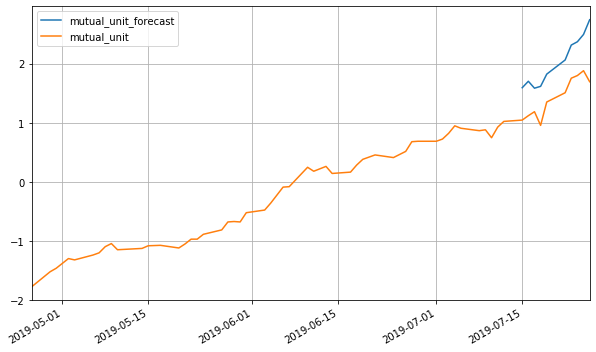

In [46]:
dfcompare.plot(figsize=(10,6),grid=True)